# Hyper-parameter Investigation

Hyper-parameters to be investigated: <br>
1. Number of hidden layers <br>
2. Number of nodes per layer <br>
3. The type of activation function used in each layer <br>
4. The learning rate <br>
5. The number of epochs <br>

Baseline parameters used for the network (unless otherwise specified):
- Leaky ReLU activation function for hidden layers
- Sigmoid activation function for the output layer 
- A single training cycle consists of 2000 epochs 
- Default learning rate is 0.05

## Setup

In [1]:
import time
import funcs
import network as net
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Step 1:** Get the data 

In [3]:
# The input data (each row is an instance)
data = pd.read_csv("data_banknote_authentication.txt",
    sep=",",
    header=None,
)
x = data.iloc[:, 0:3].to_numpy()
y = data.iloc[:, 4].to_numpy()

# Test data set to check for overfitting (20% of overall set)
split_index = round(y.shape[0] * 0.2)

x_test = x[:split_index]
y_test = y[:split_index]

x = x[split_index:]
y = y[split_index:]

**Step 2:** Method for initiating and training the network

In [4]:
def train_nn(nr_layers, nr_nodes, activation_func, learning_rate, nr_epochs):
    layers = []
    for _ in range(nr_layers):
        layers.append(net.layer(nr_nodes, activation_func))
    layers.append(net.layer(1, funcs.sigmoid)) # add the output layer with sigmoid as activation func
    
    n = net.network(x, layers, y, alpha=learning_rate)
    
    start_time = time.time()
    acc, loss, acc_t, loss_t  = n.train(nr_epochs, x_test, y_test[:, np.newaxis])
    t_time = time.time() - start_time # training time

    return acc, loss, acc_t, loss_t, t_time

In [5]:
from typing import Iterable

def evaluate_parameters(
    average_over = 10,
    epochs = 200,
    alphas = 0.1,
    hidden_layers = 2,
    layer_nodes = 4,
    act_funcs = funcs.leaky_relu
):
    if (isinstance(alphas, Iterable)):
        model_count = len(alphas)
    if (isinstance(hidden_layers, Iterable)):
        model_count = len(hidden_layers)
    if (isinstance(layer_nodes, Iterable)):
        model_count = len(layer_nodes)
    if (isinstance(act_funcs, Iterable)):
        model_count = len(act_funcs)

    # Metric tracking storage
    accuracy = np.zeros((model_count, epochs))
    loss =  np.zeros((model_count, epochs))
    accuracy_test = np.zeros((model_count, epochs))
    loss_test =  np.zeros((model_count, epochs))
    avg_training_time = np.zeros((model_count, average_over))

    # Can only vary one hyperparameter at once
    if (isinstance(alphas, Iterable)):
        for i in range(average_over):
            for j, alpha in enumerate(alphas):
                an, ln, an_t, ln_t, tn = train_nn(
                    hidden_layers,
                    layer_nodes,
                    act_funcs,
                    alpha,
                    epochs
                )

                # Averaging as we go via weighted sum
                accuracy[j] += an / average_over
                loss[j] += ln / average_over
                accuracy_test[j] += an_t / average_over
                loss_test[j] += ln_t / average_over
                # Need full time data for summary stats
                avg_training_time[j,i] = tn
    if (isinstance(hidden_layers, Iterable)):
        for i in range(average_over):
            for j, layers in enumerate(hidden_layers):
                an, ln, an_t, ln_t, tn = train_nn(
                    layers,
                    layer_nodes,
                    act_funcs,
                    alphas,
                    epochs
                )

                # Averaging as we go via weighted sum
                accuracy[j] += an / average_over
                loss[j] += ln / average_over
                accuracy_test[j] += an_t / average_over
                loss_test[j] += ln_t / average_over

                avg_training_time[j,i] = tn
    if (isinstance(layer_nodes, Iterable)):
        for i in range(average_over):
            for j, nodes in enumerate(layer_nodes):
                an, ln, an_t, ln_t, tn = train_nn(
                    hidden_layers,
                    nodes,
                    act_funcs,
                    alphas,
                    epochs
                )

                # Averaging as we go via weighted sum
                accuracy[j] += an / average_over
                loss[j] += ln / average_over
                accuracy_test[j] += an_t / average_over
                loss_test[j] += ln_t / average_over

                avg_training_time[j,i] = tn
    if (isinstance(act_funcs, Iterable)):
        for i in range(average_over):
            for j, act_func in enumerate(act_funcs):
                an, ln, an_t, ln_t, tn = train_nn(
                    hidden_layers,
                    layer_nodes,
                    act_func,
                    alphas,
                    epochs
                )

                # Averaging as we go via weighted sum
                accuracy[j] += an / average_over
                loss[j] += ln / average_over
                accuracy_test[j] += an_t / average_over
                loss_test[j] += ln_t / average_over

                avg_training_time[j,i] = tn

    return accuracy, accuracy_test, loss, loss_test, avg_training_time

In [6]:
def graph_metrics(hyper_param: str, legend, accuracy, accuracy_test, loss, loss_test, training_times):
    plt.rcParams.update({'font.size': 20})

    fig = plt.figure(figsize=(30, 10))

    subplot = fig.add_subplot(1,2,1)
    subplot.title.set_text('Training Metrics')
    subplot.set_xlabel('Epochs')
    subplot.set_ylabel('Accuracy')

    for i, a in enumerate(accuracy):
        subplot.plot(a, linestyle = 'solid', label = f'{hyper_param}: {legend[i]}')

    plt.legend(loc=4)

    subplot = fig.add_subplot(1,2,2)
    subplot.title.set_text('Testing Metrics')
    subplot.set_xlabel('Epochs')
    subplot.set_ylabel('Accuracy')

    for i, a in enumerate(accuracy_test):
        subplot.plot(a, linestyle = 'solid', label = f'{hyper_param}: {legend[i]}')

    plt.legend(loc=4)
    plt.show()


    fig = plt.figure(figsize=(30, 10))

    subplot = fig.add_subplot(1,2,1)
    subplot.title.set_text('Training Metrics')
    subplot.set_xlabel('Epochs')
    subplot.set_ylabel('Loss')

    for i, a in enumerate(loss):
        subplot.plot(a, linestyle = 'solid', label = f'{hyper_param}: {legend[i]}')

    plt.legend(loc=0)

    subplot = fig.add_subplot(1,2,2)
    subplot.title.set_text('Testing Metrics')
    subplot.set_xlabel('Epochs')
    subplot.set_ylabel('Loss')

    for i, a in enumerate(loss_test):
        subplot.plot(a, linestyle = 'solid', label = f'{hyper_param}: {legend[i]}')

    plt.legend(loc=0)

    plt.show()


    plt.figure(figsize=(15, 10))
    plt.boxplot(training_times.T, labels=legend, vert=True)
    plt.title('Training Time Spead of 10 Repetitions')
    plt.xlabel(hyper_param)
    plt.ylabel('Training Time (s)')

    plt.show()

    return np.array(training_times)


## 1. Number of hidden layers

Investigate the accuracy of neural networks with varying numbers of hidden layers (0 to 10). To isolate the effect of the number of hidden layers on a network's performance, each layer has a single nodes. Performance metrics used to evaluate the model are - average accuracy, loss and training time calculated form 10 trial runs of the model.

**Step 1:** Train the network and plot the performance metrics

In [7]:
hidden_layers = list(range(0,5))
metrics_layers = evaluate_parameters(hidden_layers = hidden_layers)

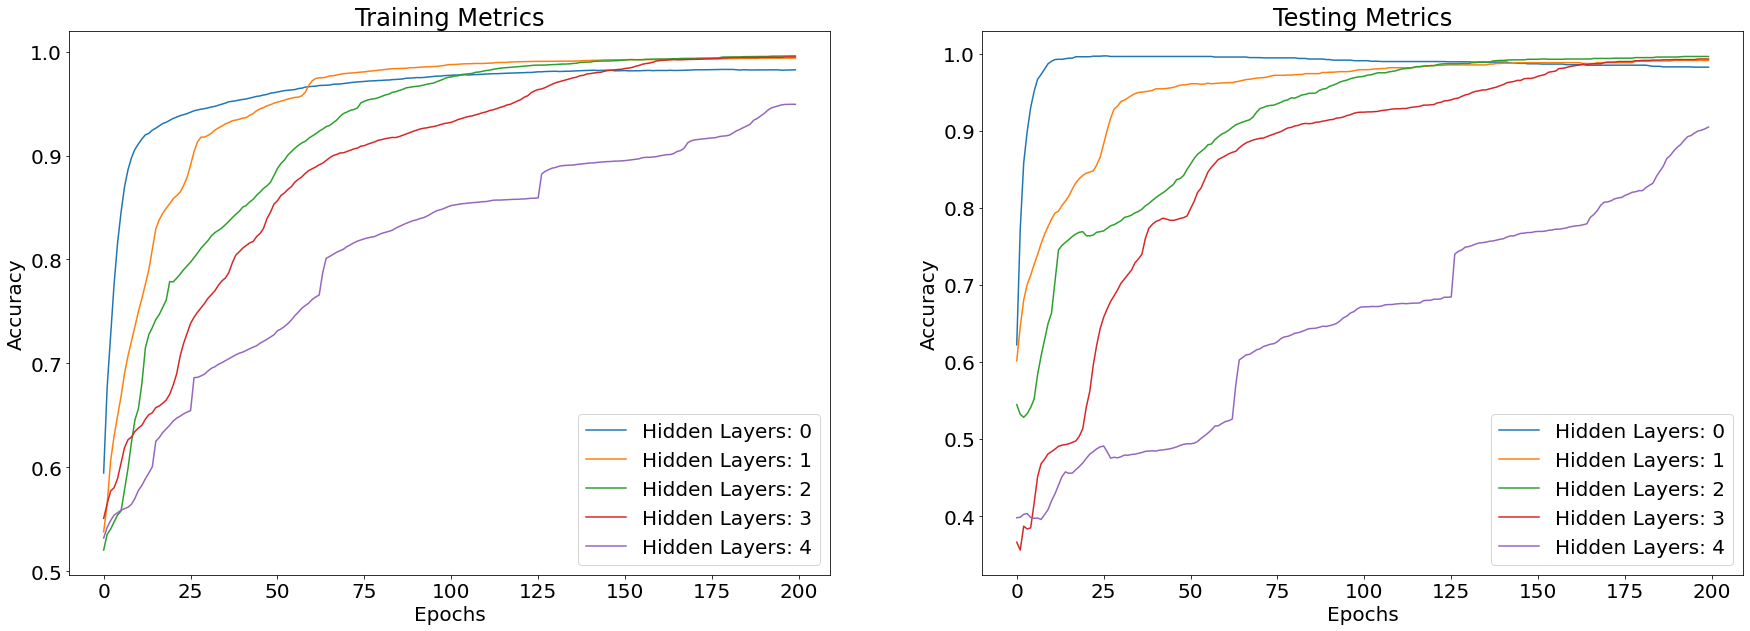

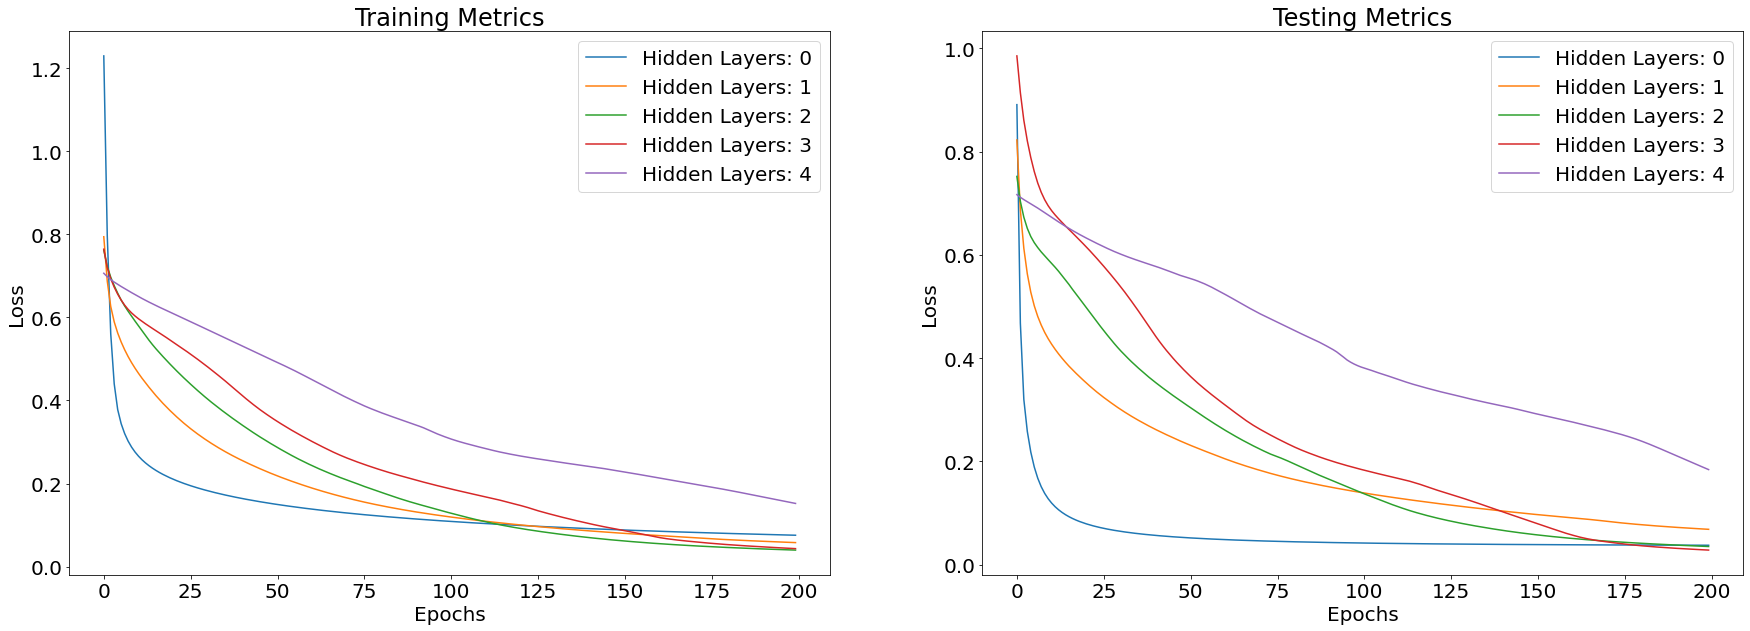

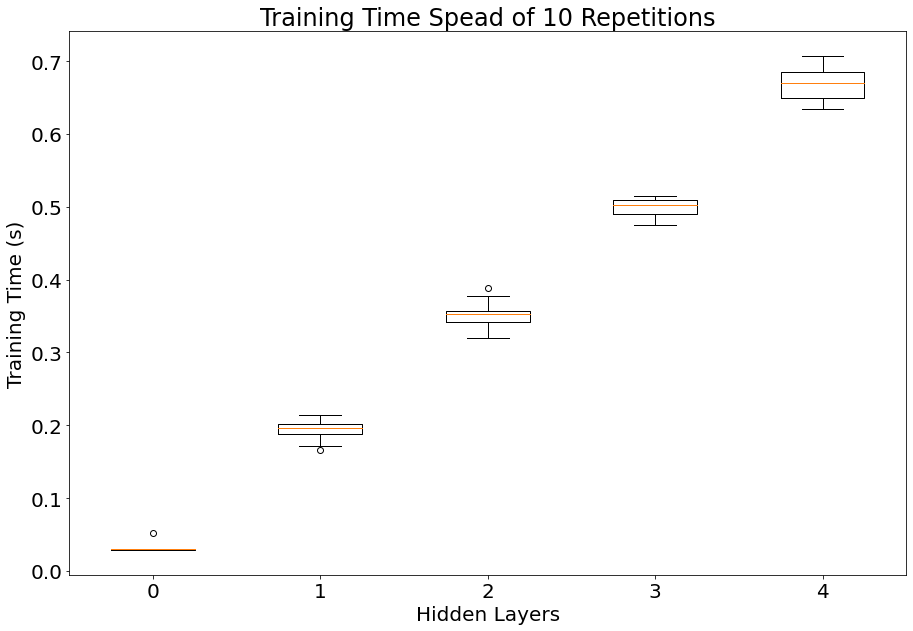

In [8]:
layer_times = graph_metrics('Hidden Layers', hidden_layers, *metrics_layers)

## 2. Number of nodes per layer

Next, investigate the effect of the number of nodes per layer on a network's performance. In the previous experiment networks with 2, 4, and 6 hidden layers performed best (**perhaps this is not the best way to reason about this, the accuracy in the previous section changes dramatically from run to run, as well if the activation is changed**), therefore these architectures will be used as baseline and the number of nodes altered (exclude networks with single node per layer as this scenario was explored in the previous section).  

In [9]:
layer_nodes = list(range(1,6))
metrics_nodes = evaluate_parameters(layer_nodes = layer_nodes)

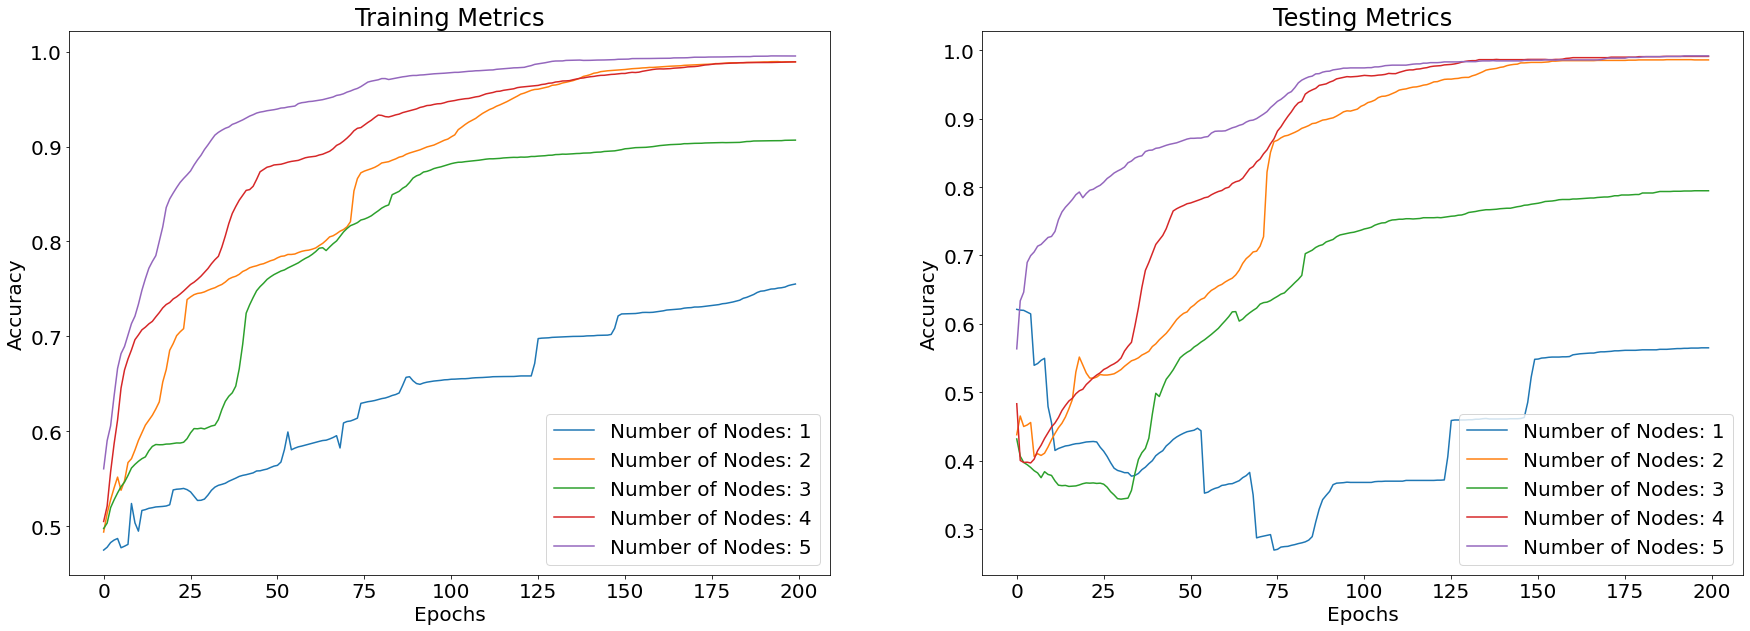

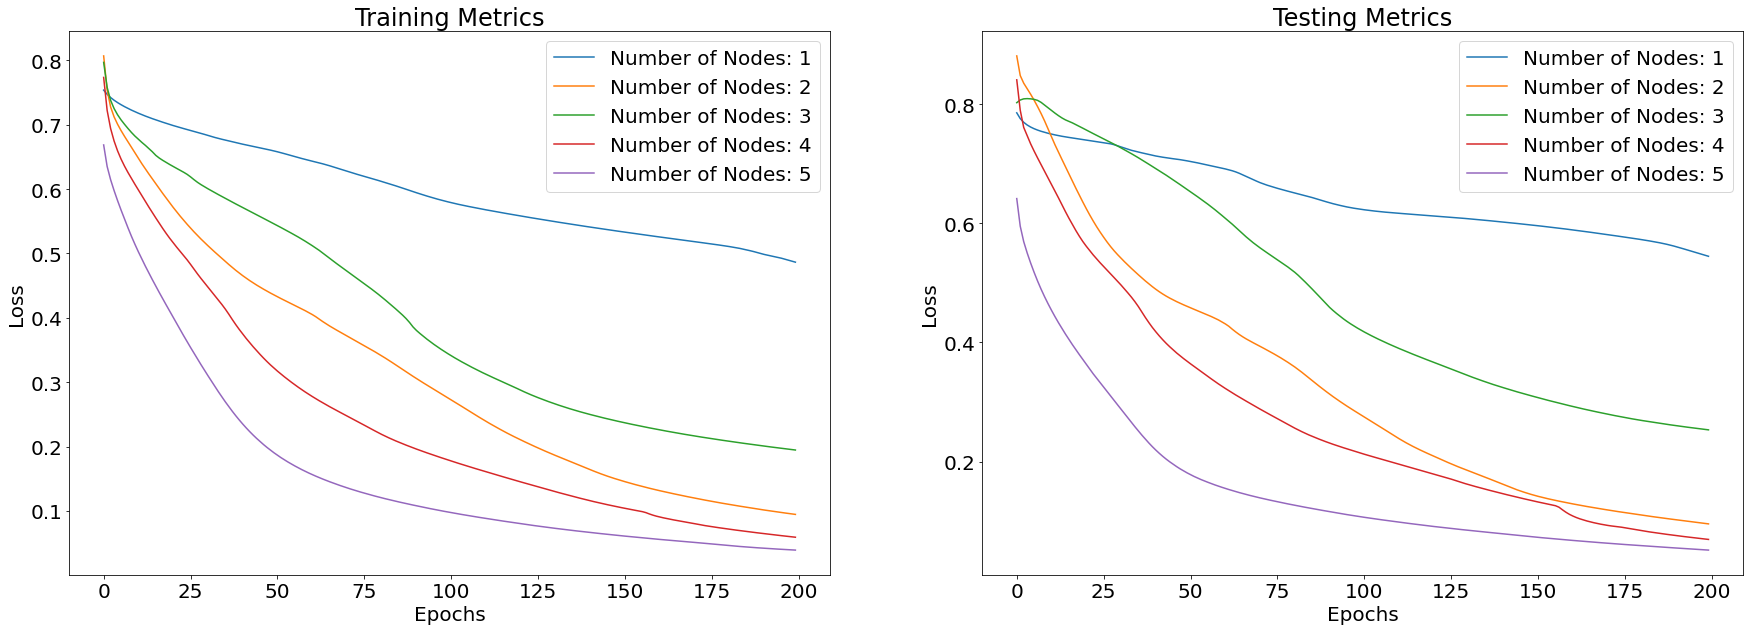

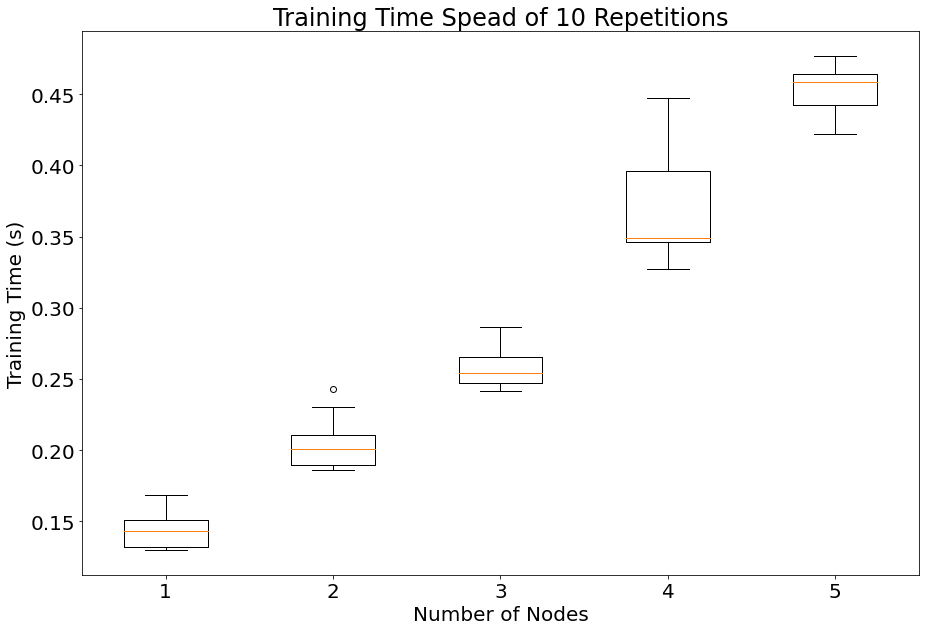

In [10]:
node_times = graph_metrics('Number of Nodes', layer_nodes, *metrics_nodes)

## 3. Type of activation function

Explore the effect of activation function used in the hidden layers on the model's performance. For the final output to be in the range between 0 and 1 (necessary to evaluate the model's performance using the loss function), sigmoid activation function is used in the output layer.
Activation functions used:
- Logistic activation function (**sigmoid**)
- Hyperbolic tangent activation function (**tanh**)
- Rectified Linear Unit activation function (**relu**)
- Leaky ReLU activation function (**leaky_relu**)

In [11]:
metrics_funcs = evaluate_parameters(act_funcs = [funcs.sigmoid, funcs.tanh, funcs.relu, funcs.leaky_relu])

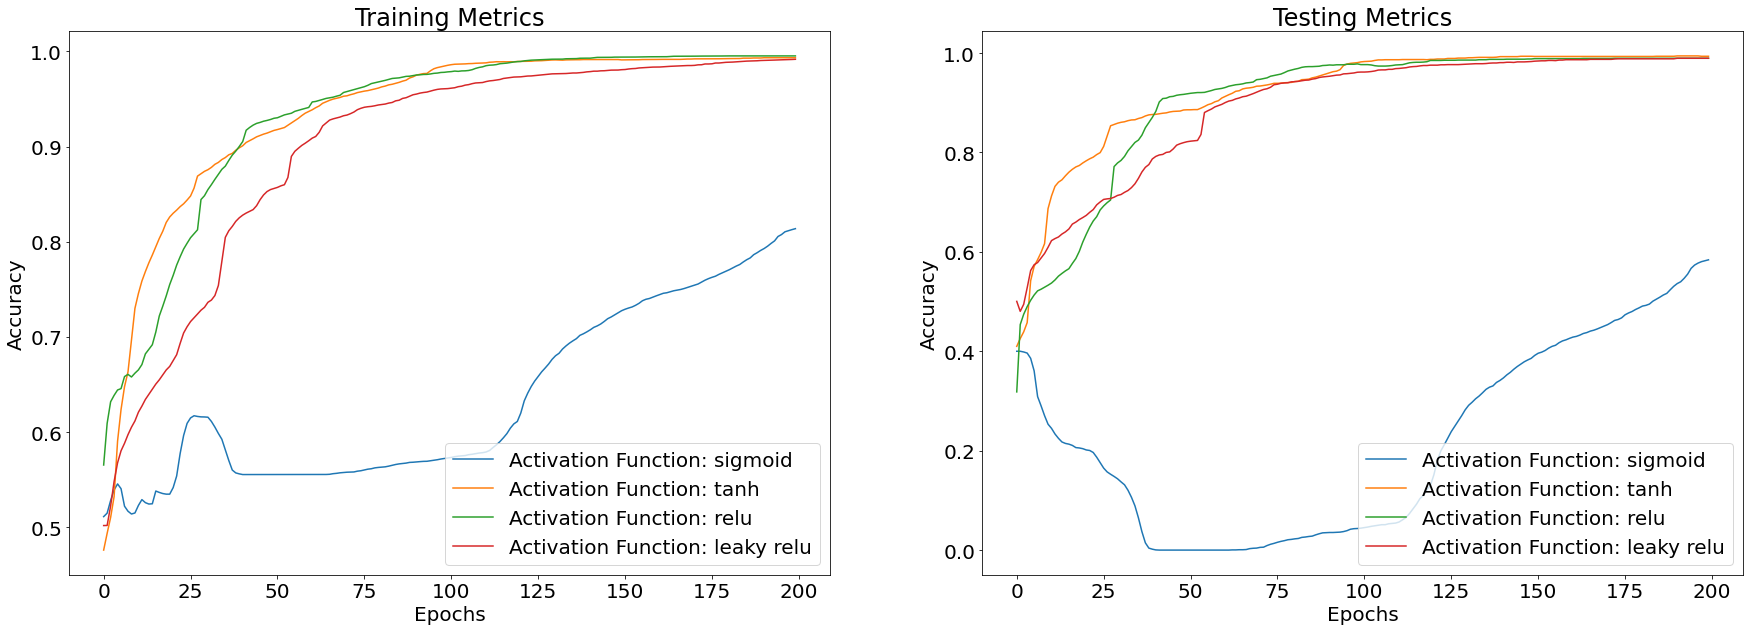

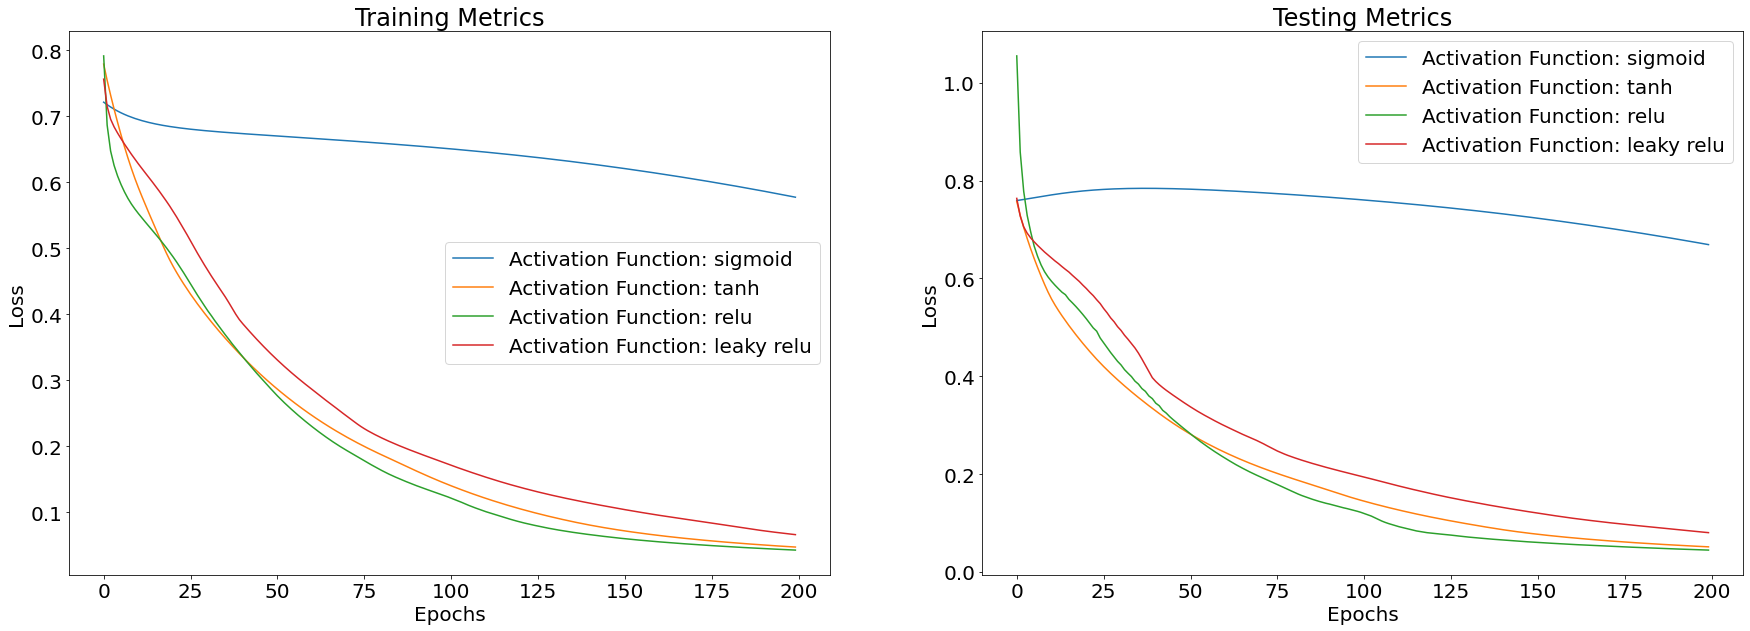

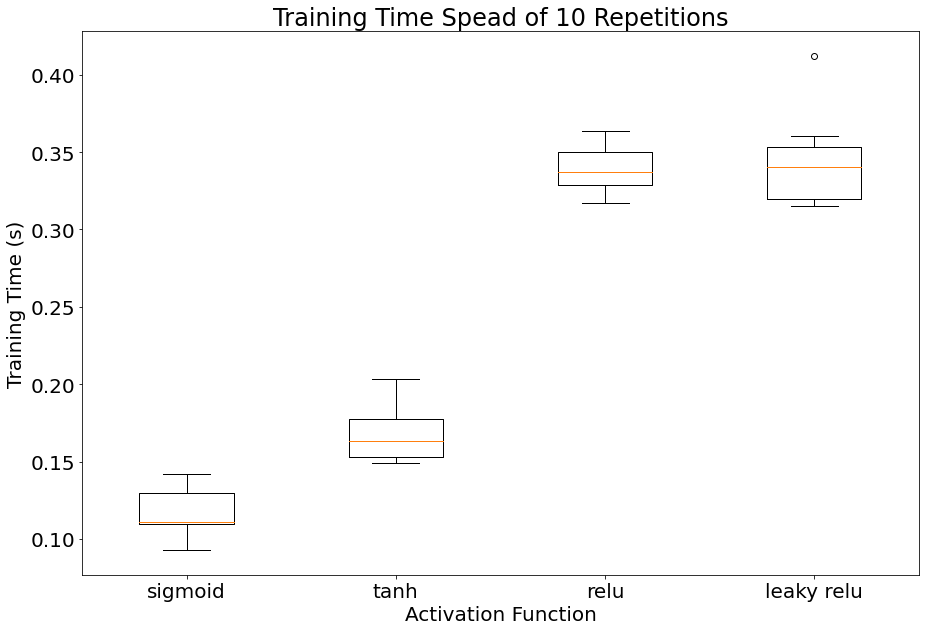

In [12]:
func_times = graph_metrics('Activation Function', ['sigmoid', 'tanh', 'relu', 'leaky relu'], *metrics_funcs)

## 4. Learning rate 

In [15]:
alphas = [0.2, 0.1, 0.05, 0.01, 0.05]
metrics_alpha = evaluate_parameters(alphas = alphas)

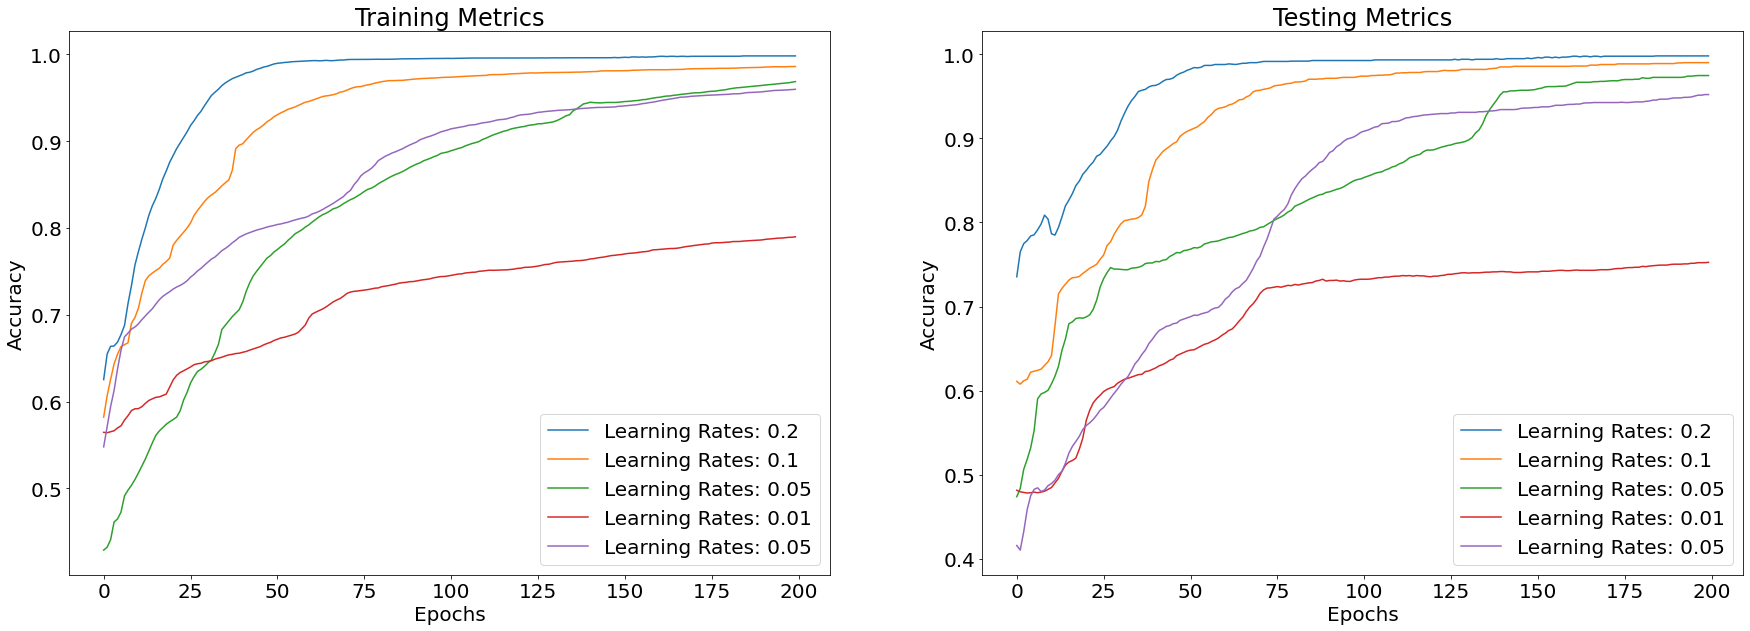

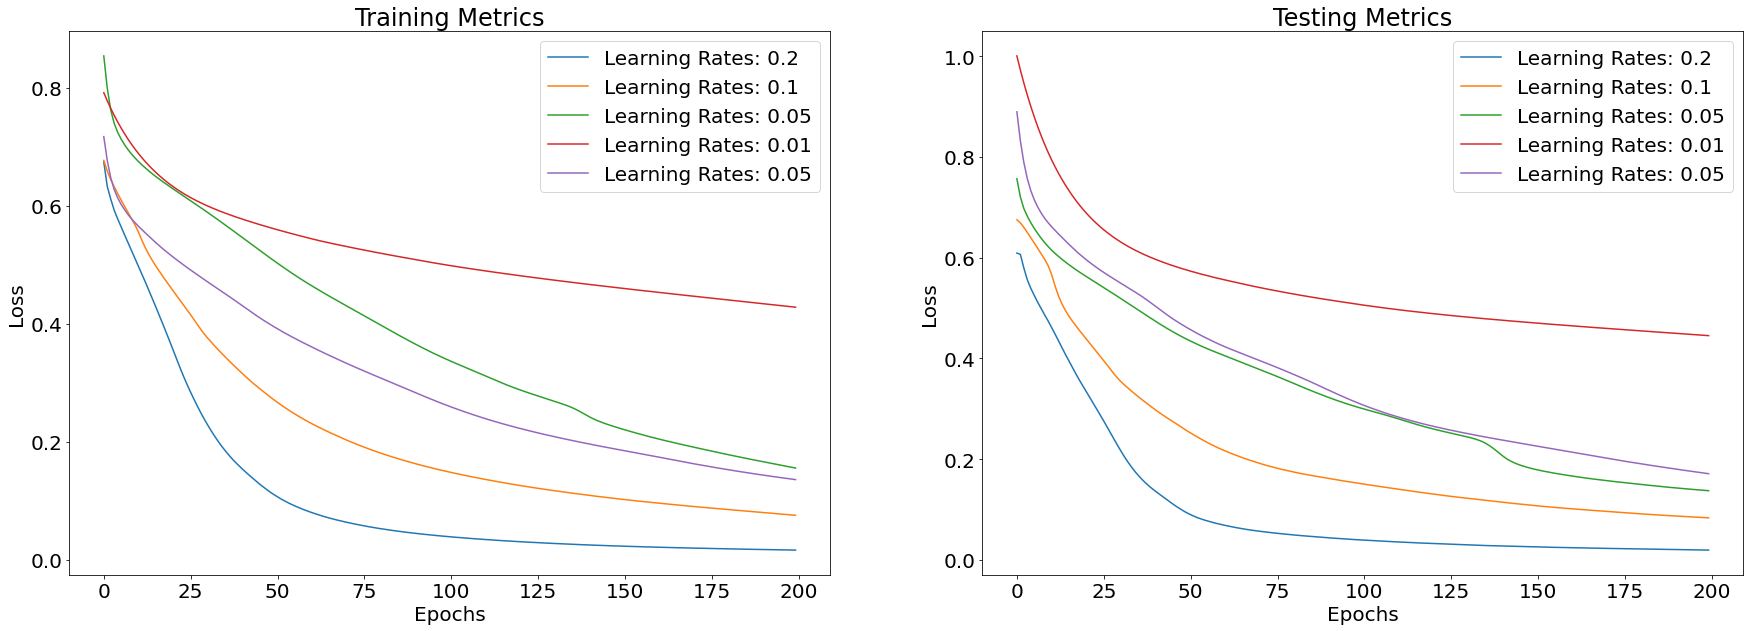

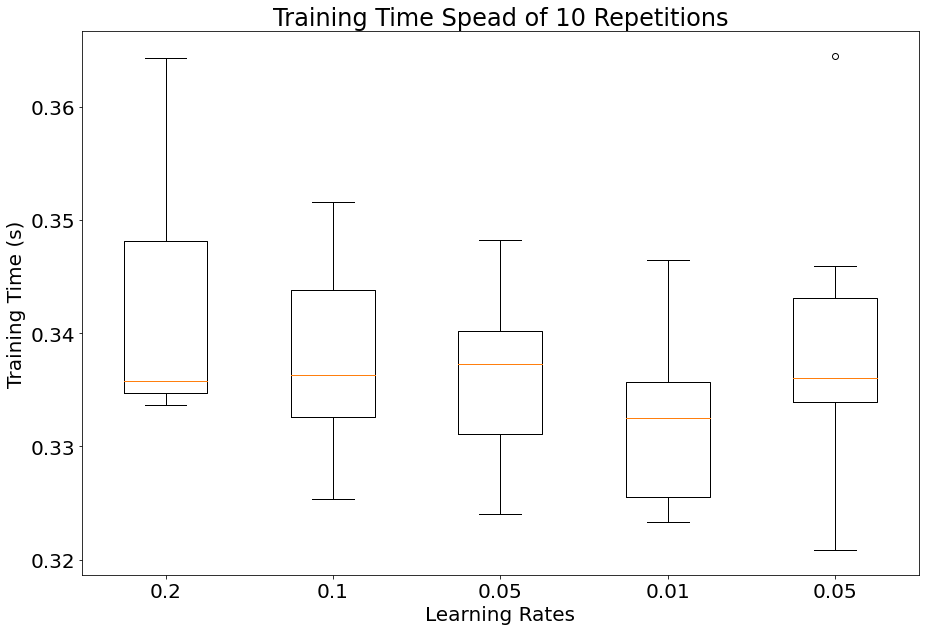

In [16]:
alpha_times = graph_metrics('Learning Rates', alphas, *metrics_alpha)

## Combo Training Times Boxplot

In [17]:

df = pd.DataFrame(data=layer_times.T, columns=['L0', 'L1', 'L2', 'L3', 'L4'])

In [18]:
for i in range(node_times.shape[0]):
    column = "N{}".format(i+1)
    df[column] = node_times[i]

funcs = ['S', 'T', 'R', 'LR']
for i in range(func_times.shape[0]):
    df[funcs[i]] = func_times[i]

for i in range(alpha_times.shape[0]):
    df[alphas[i]] = alpha_times[i]

Text(0.5, 1.0, 'Average training time')

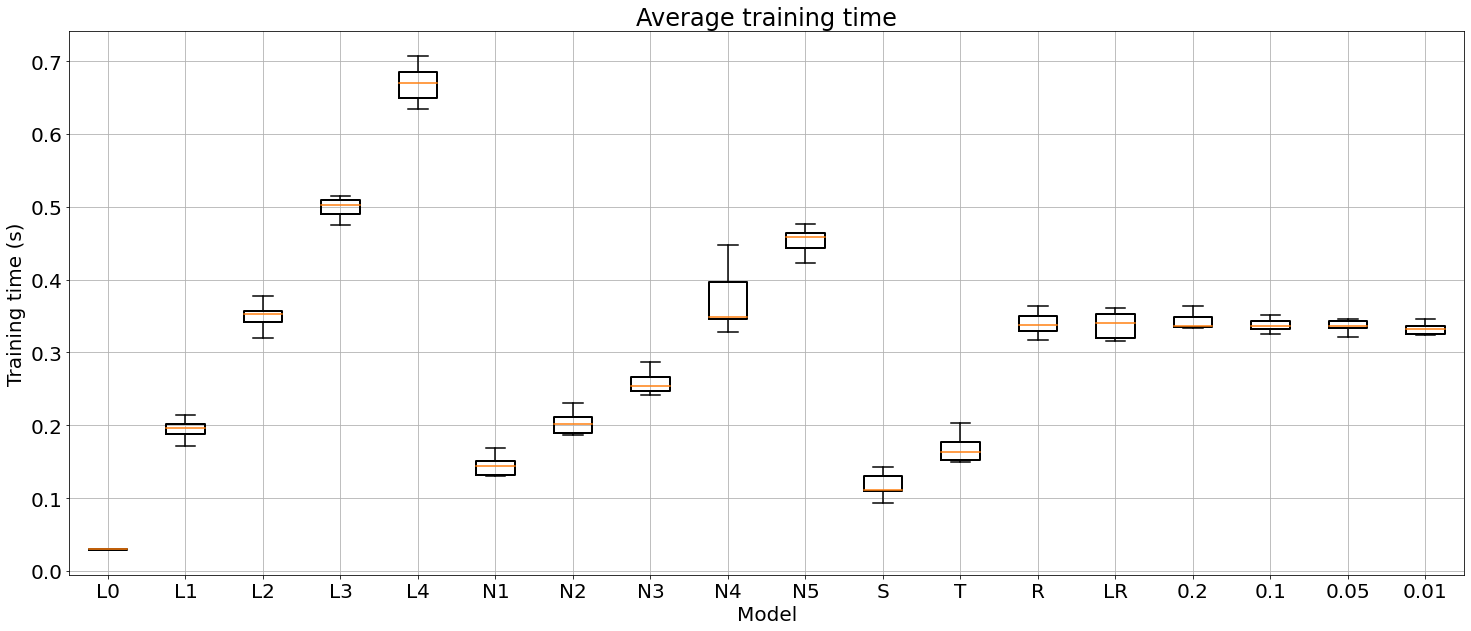

In [19]:
boxplot = df.boxplot(figsize=(25, 10), boxprops=dict(linestyle='-', linewidth=2), showfliers=False, grid=True, rot=0, 
             flierprops=dict(linestyle='-', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5))
boxplot.set_ylabel("Training time (s)")
boxplot.set_xlabel("Model")
boxplot.set_title("Average training time")